In [ ]:
from scipy.stats import beta as beta_dist
from plotting_utils import plot_gaussian_hypothesis_test
from plotting_utils import plot_type_ii_error_analysis, plot_beta_prior_comparison, plot_prior_vs_posterior
from plotting_utils import plot_informative_prior_posterior_comparison, plot_weakly_informative_prior_with_variants
from plotting_utils import plot_multiple_posteriors_comparison

<style>
.reveal h1 { font-size: 1.8em; color: #4a90d9; }
.reveal h2 { font-size: 1.4em; color: #4a90d9; }
.reveal h3 { font-size: 1.1em; color: #4a90d9; }
.reveal { color: #333; }
</style>

# From Manual Bayesian A/B Tests to Automated Thompson Sampling

**A guide to modern A/B testing for web and mobile product teams**

<br><br><br><br>

<p style="font-size: 0.6em; color: #666; line-height: 1.6;">
All the notebooks with running code can be cloned from
<br><a href="https://github.com/alaindemour/ABtest_methodologies" style="color: #4a90d9;">https://github.com/alaindemour/ABtest_methodologies</a>
<br>Created with the help of Claude Sonnet 4.6
</p>

# Presentation Overview

1. **Classical vs. Bayesian Statistics**
2. **Why Bayesian is Better** for CX / pricing A/B tests
3. **Non-Inferiority Test** — NHST fails, Bayesian succeeds
4. **Select Best Variant** — direct probability
5. **Corporate Iteration Speed** — the deployment bottleneck
6. **Thompson Sampling** — the fully automated solution



# Part 1: Classical vs. Bayesian Statistics

## The Fundamental Questions

The methodolgies start with opposite directions questions. Classical statistics a.k.a. Frequentist is using a methodology called Null Hypothesis Signifance Testing (NHST), if you hear  "p values" or "thia experimentis under powered " it is NHST

| Framework | Question | Notation |
|-----------|----------|----------|
| **NHST** | "How likely is this observation, assuming $H_0$?" | p(data \| θ ) |
| **Bayesian** | "How likely is the hypothesis, given the observation?" |p(θ \| data) |


## NHST in a Nutshell

1. Assume $H_0$ as what you don't want to be true e.g. **the new drug has no effect** or **the new passkey creation UX degrades conversion**
2. Compute a "test statistic" from the observed data, in this presentaiton is a mean but can be any statisitcal measure 
3. If result is "unlikely enough" (p-value < 0.05), reject $H_0$

### Key Caveats

- Rejecting $H_0$ does **not** prove the alternative
- The 5% threshold is a **convention**, not a law of nature
- No quantified probability of being correct — just "unlikely" or "not unlikely"
- The math involved requires large samples for significance and does not "compose" well


## Bayesian in a Nutshell

1. Pick a **prior belief** distribution for the measure we are interest in (conventionally noted as $\theta$ and also called "the parameter")
2. Observe data
3. Apply **Bayes' theorem** → get **posterior belief**

$$\boxed{P(\theta \mid \text{data}) = \frac{P(\text{data} \mid \theta) \cdot P(\theta)}{P(\text{data})}}$$

✅ 4. The Posterior belief can become the prior belief for the next update

Full probability distribution — compute anything you need at any time during the experiment:
point estimates, credible intervals, P(better than threshold), expected values

In [ ]:
# Bayesian Update: weakly informative prior → posterior after moderate data
# Prior: Beta(2, 2) — weakly informative, spread across full [0,1]
# Data: 12 successes in 20 trials (60% rate)
# Posterior: Beta(14, 10) — shifted toward 0.6 but still broad
alpha_prior, beta_prior = 2, 2
n_obs, k_obs = 20, 12
alpha_post = alpha_prior + k_obs
beta_post = beta_prior + (n_obs - k_obs)

fig, ax, _, _ = plot_informative_prior_posterior_comparison(
    alpha_prior=alpha_prior,
    beta_prior=beta_prior,
    alpha_posterior=alpha_post,
    beta_posterior=beta_post,
    x_limits=(0, 1)
)
print(f"Prior: Beta({alpha_prior},{beta_prior}) — mean={alpha_prior/(alpha_prior+beta_prior):.0%}")
print(f"Data: {k_obs} successes in {n_obs} trials")
print(f"Posterior: Beta({alpha_post},{beta_post}) — mean={alpha_post/(alpha_post+beta_post):.0%}")

In [ ]:
# Plot comparison of different Beta prior distributions
fig, axes = plot_beta_prior_comparison()

# Part 2: Why Bayesian is Better

## NHST Problems for Product A/B Tests

| Problem | Impact |
|---|---|
| **Small samples** | At launch, n=150 per variant. NHST: "inconclusive." |
| **p-value hacking** | Can't peek at results without inflating false positives |
| **Unbalanced samples** | 7,000 control vs. 150 variant — NHST loses power |
| **Binary output** | "Reject" or "fail to reject" — no probabilities |

## Where Bayesian Excels

| Advantage | Detail |
|---|---|
| **Small samples** | Prior knowledge + data = meaningful conclusions |
| **Unbalanced allocation** | Each variant analyzed independently |
| **Many variants** | No multiple comparison penalties |
| **Actionable output** | "47% chance B is best" — not just reject/fail |
| **Continuous monitoring** | Check anytime, no p-hacking concerns |

## FDA Embraces Bayesian (January 2026)

> The FDA issued draft guidance: **"Use of Bayesian Methodology in Clinical Trials of Drugs and Biological Products"**

If the most conservative regulator in the world is adopting Bayesian methods, the case for product A/B testing is even stronger.

**When does it *not* matter?** Once you have millions of data points and can wait weeks, both approaches converge. The advantage is in the **early, high-uncertainty phase**.

# Part 3: Non-Inferiority Test

## The Setup

- Existing flow: **~71% completion rate**
- Adding passkey creation (extra pages/clicks)
- **Question**: Does the new experience cause unacceptable degradation?
- **Non-inferiority margin**: $\epsilon$ = 2%

| Group | Sample size | Conversion rate |
|-------|-----------|----------------|
| Control | 32,106 | 70.9% |
| Variant A | 4,625 | 70.1% |
| Variant B | 2,100 | 68.2% |
| Variant C | 2,022 | 69.0% |

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, beta as beta_dist

# --- Experiment Data ---
nC = 32106
xC = 22772
control_rate = xC / nC

variants = {
    'A': {'n': 4625, 'x': 3244},
    'B': {'n': 2100, 'x': 1433},
    'C': {'n': 2022, 'x': 1396}
}

epsilon = 0.02  # 2% non-inferiority margin

print(f"Control: n={nC:,}, rate={control_rate:.2%}")
for name, d in variants.items():
    r = d['x'] / d['n']
    print(f"Variant {name}: n={d['n']:,}, rate={r:.2%}")
print(f"\nNon-inferiority margin (epsilon): {epsilon:.0%}")
print(f"Non-inferiority threshold: {control_rate - epsilon:.2%}")

## NHST Result: Inconclusive

**p-value ~ 0.45** — far from the 5% threshold

NHST says: "We can't say anything."

The test is **severely underpowered** with n=2,022.

In [ ]:
# NHST non-inferiority test on Variant C
nX = variants['C']['n']
xX = variants['C']['x']
hatpC = xC / nC
hatpA = xX / nX
hatDelta = hatpA - hatpC

# Unpooled SE (appropriate for non-inferiority)
SE = np.sqrt(hatpC * (1 - hatpC) / nC + hatpA * (1 - hatpA) / nX)
mu_H0 = -epsilon

# p-value: right tail P(Delta >= observed | H0)
p_value = norm.sf(hatDelta, loc=mu_H0, scale=SE)

# Power analysis
pooled_p = (xC + xX) / (nC + nX)
SE_H1 = np.sqrt(pooled_p * (1 - pooled_p) * (1/nC + 1/nX))
critical_value = norm.isf(0.05, loc=mu_H0, scale=SE)
power = 1 - norm.cdf(critical_value, loc=0, scale=SE_H1)

print("NHST Non-Inferiority Test (Variant C)")
print("=" * 50)
print(f"Observed difference: {hatDelta:.4f}")
print(f"Standard error: {SE:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Power: {power:.1%}")
print()
if p_value <= 0.05:
    print("Result: REJECT H0 — non-inferiority established")
else:
    print("Result: FAIL TO REJECT — inconclusive")
    print(f"  (Power is only {power:.1%} — test is severely underpowered)")
    print(f"  NHST cannot help us with n={nX} for this variant.")

## Bayesian: Actionable Answer

<!-- **Weakly informative prior** centered on expected performance:

$$\text{Beta}(\alpha_0, \beta_0) + \text{Data} \Rightarrow \text{Beta}(\alpha_0 + k, \; \beta_0 + n - k)$$

Then directly compute: $P(\text{variant} > \text{control} - \epsilon)$ -->

In [ ]:
from bayesian import test_non_inferiority_weakly_informative
from plotting_utils import plot_weakly_informative_prior_with_variants

# Run Bayesian non-inferiority test on all variants
expected_degradation = 0.01  # Domain knowledge: adding clicks may degrade by ~1%

results_ni = test_non_inferiority_weakly_informative(
    n_control=nC,
    x_control=xC,
    variants_data=variants,
    epsilon=epsilon,
    expected_degradation=expected_degradation,
    alpha_prior_strength=20,  # Weak prior (high entropy)
    threshold=0.95
)

print("Bayesian Non-Inferiority Test Results")
print("=" * 60)
print(f"Prior centered at: {control_rate - expected_degradation:.2%}")
print(f"Test threshold: {control_rate - epsilon:.2%}")
print()


In [ ]:

for name, res in results_ni.items():
    status = "NON-INFERIOR" if res['is_non_inferior'] else "NOT NON-INFERIOR"
    observed_rate = variants[name]['x'] / variants[name]['n']
    print(f"Variant {name}: {status}")
    print(f"  Observed rate: {observed_rate:.2%}, Posterior mean: {res['variant_rate']:.2%}")
    print(f"  P(variant > threshold): {res['probability']:.2%}")
    print()


In [ ]:

# Visualize
fig, ax = plot_weakly_informative_prior_with_variants(results_ni)

## Takeaway: Same Data, Different Answers

| Method | Variant C Result | Actionable? |
|--------|-----------------|-------------|
| **NHST** | p ~ 0.45, "fail to reject" | No |
| **Bayesian** | P(non-inferior) > 95% | **Yes** |

# Part 4: Select Best Variant

## NHST Can't Answer "Which is Best?"

| Approach | Problem |
|---|---|
| Highest observed rate | Ignores uncertainty |
| Pairwise t-tests + Bonferroni | Very conservative |
| ANOVA + post-hoc | Only says "something differs" |

**None directly answer**: "What is P(A is best)?""

## Bayesian: Direct Probability

1. Compute **posterior Beta** for each variant
2. **Monte Carlo**: draw 100k samples from each
3. Count how often each variant wins

Result: $P(A \text{ is best}) = 88\%$, $P(B) = 3\%$, $P(C) = 9\%$

No corrections needed. Scales to any number of variants.

In [ ]:
from bayesian import select_best_variant
from plotting_utils import plot_multiple_posteriors_comparison

# Select the best variant using Monte Carlo simulation
selection = select_best_variant(
    variants_data=variants,
    alpha_prior=1,   # Non-informative prior for fair comparison
    beta_prior=1,
    credible_level=0.95,
    n_simulations=100000
)

# Display results
print("Probability Each Variant is Best")
print("=" * 50)
for name in ['A', 'B', 'C']:
    prob = selection['probabilities'][name]
    bar = '#' * int(prob * 50)
    print(f"  P({name} is best) = {prob:.2%}  {bar}")

winner = selection['best_variant']
print(f"\nWinner: Variant {winner}")
print(f"  Probability of being best: {selection['probabilities'][winner]:.2%}")
print(f"  Posterior mean: {selection['posterior_means'][winner]:.2%}")
ci = selection['credible_intervals'][winner]
print(f"  95% Credible interval: [{ci[0]:.2%}, {ci[1]:.2%}]")
print(f"  Expected loss: {selection['expected_loss'][winner]:.4f}")

# Visualize posterior distributions
posteriors = {}
for name, data in variants.items():
    alpha_post = data['x'] + 1
    beta_post = data['n'] - data['x'] + 1
    posteriors[name] = {
        'alpha': alpha_post,
        'beta': beta_post,
        'mean': alpha_post / (alpha_post + beta_post),
        'ci_95': (beta_dist.ppf(0.025, alpha_post, beta_post),
                  beta_dist.ppf(0.975, alpha_post, beta_post))
    }

fig, ax = plot_multiple_posteriors_comparison(
    posteriors=posteriors,
    control_group_conversion_rate=control_rate,
    epsilon=epsilon
)
plt.show()

# Part 5: The Deployment Bottleneck

## Real-World Timeline

| Date | Event |
|------|-------|
| **Early Nov** | Variant A wins with >88% probability |
| **Mid Nov** | Release freeze (Black Friday) |
| **Late Nov** | Bug in traffic splitter |
| **December** | Legal review + holiday delays |
| **January** | Winner finally deployed |

**2 months** from "we know" to "users benefit."

## The Solution: Automate the Decision Loop

**Cost of delay**: 2% better conversion x 10,000 users/day x 60 days = **~12,000 lost conversions**

> Instead of: Experiment → Analyze → Decide → Wait → Deploy
>
> We get: Deploy all variants → **Algorithm optimizes automatically**

This is **Thompson Sampling**.

# Part 6: Thompson Sampling

## The Multi-Armed Bandit Problem

<div style="display: flex; align-items: center; gap: 40px;">
<div style="flex: 1;">

**Casino analogy**: K slot machines, unknown payouts, limited budget.

| Casino | A/B Testing |
|--------|-------------|
| Slot machines | Variants |
| Pull lever | Show variant |
| Payout | User converts |

**Dilemma**: Explore (try machines) vs. Exploit (play the best)

</div>
<div style="flex: 0 0 auto; text-align: center;">
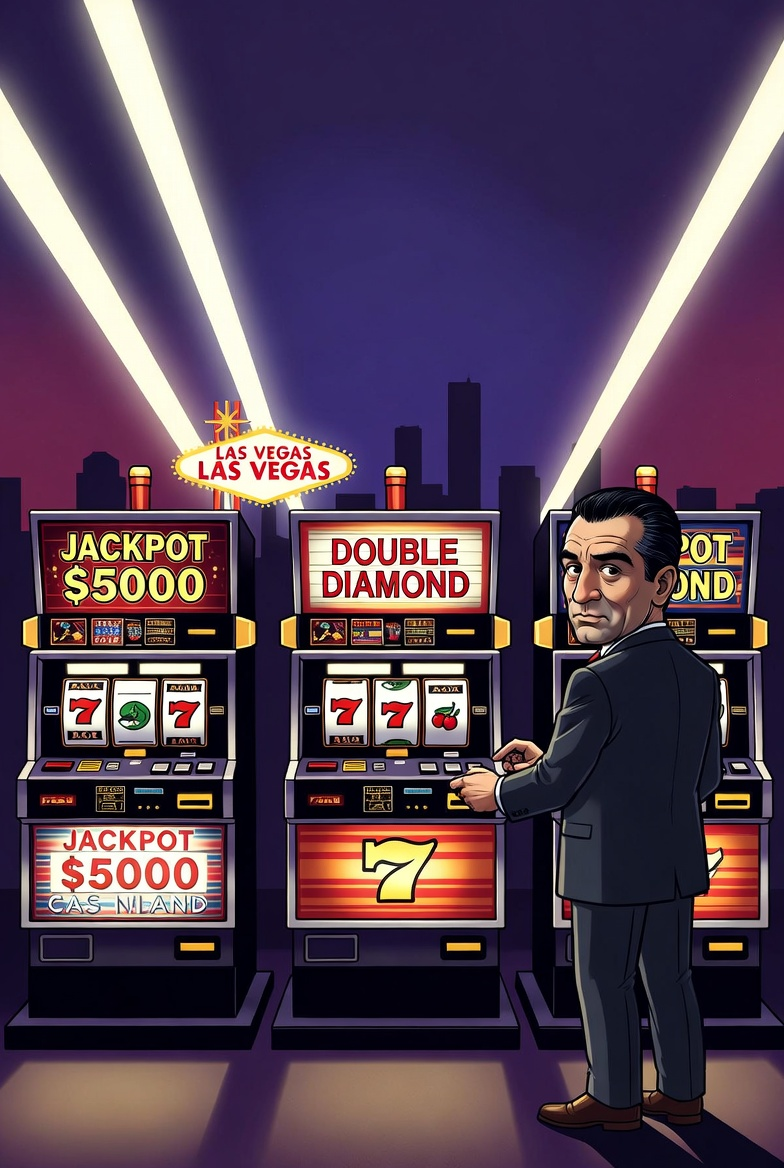
</div>
</div>

## The Algorithm (5 Lines of Logic)

For each user:

1. **Sample** from each posterior: $\theta_i \sim \text{Beta}(\alpha_i, \beta_i)$
2. **Choose** variant with highest sample
3. **Show** it to the user
4. **Observe** conversion (0 or 1)
5. **Update** posterior: $\alpha \mathrel{+}= r$, $\beta \mathrel{+}= (1-r)$

**Early**: wide posteriors → exploration
**Later**: narrow posteriors → exploitation

In [ ]:
# --- Thompson Sampling Simulation ---
np.random.seed(42)

true_rates = {
    'A': 3244 / 4625,  # ~70.1%
    'B': 1433 / 2100,  # ~68.2%
    'C': 1396 / 2022,  # ~69.0%
}

def run_thompson_sampling(true_rates, n_users):
    """Simulate Thompson sampling and return results."""
    variants_list = list(true_rates.keys())
    alpha = {v: 1 for v in variants_list}
    beta = {v: 1 for v in variants_list}
    n_shown = {v: 0 for v in variants_list}
    n_conv = {v: 0 for v in variants_list}
    total_conv = 0
    
    history = {'user': [], 'prob_A': [], 'prob_B': [], 'prob_C': []}
    
    for uid in range(n_users):
        samples = {v: np.random.beta(alpha[v], beta[v]) for v in variants_list}
        chosen = max(samples, key=samples.get)
        converted = int(np.random.random() < true_rates[chosen])
        
        alpha[chosen] += converted
        beta[chosen] += (1 - converted)
        n_shown[chosen] += 1
        n_conv[chosen] += converted
        total_conv += converted
        
        if uid % 50 == 0:
            mc = 10000
            counts = {v: 0 for v in variants_list}
            for _ in range(mc):
                s = {v: np.random.beta(alpha[v], beta[v]) for v in variants_list}
                counts[max(s, key=s.get)] += 1
            history['user'].append(uid)
            for v in variants_list:
                history[f'prob_{v}'].append(counts[v] / mc)
    
    return n_shown, n_conv, total_conv, history

def run_fixed_allocation(true_rates, n_users):
    """Simulate fixed equal allocation."""
    variants_list = list(true_rates.keys())
    n_shown = {v: 0 for v in variants_list}
    n_conv = {v: 0 for v in variants_list}
    total_conv = 0
    for uid in range(n_users):
        chosen = variants_list[uid % len(variants_list)]
        converted = int(np.random.random() < true_rates[chosen])
        n_shown[chosen] += 1
        n_conv[chosen] += converted
        total_conv += converted
    return n_shown, n_conv, total_conv

n_users = 5000

# Run both strategies
ts_shown, ts_conv, ts_total, ts_history = run_thompson_sampling(true_rates, n_users)
fx_shown, fx_conv, fx_total = run_fixed_allocation(true_rates, n_users)

best = max(true_rates, key=true_rates.get)
optimal = n_users * true_rates[best]

print("THOMPSON SAMPLING vs FIXED ALLOCATION")
print("=" * 60)
print(f"{'':20s} {'Thompson':>12s} {'Fixed':>12s}")
print("-" * 60)
for v in ['A', 'B', 'C']:
    ts_pct = 100 * ts_shown[v] / n_users
    fx_pct = 100 * fx_shown[v] / n_users
    print(f"Variant {v} traffic:    {ts_pct:10.1f}%  {fx_pct:10.1f}%")
print("-" * 60)
print(f"Total conversions:  {ts_total:10d}   {fx_total:10d}")
print(f"Conversion rate:    {100*ts_total/n_users:10.2f}%  {100*fx_total/n_users:10.2f}%")
print(f"Regret:             {optimal - ts_total:10.0f}   {optimal - fx_total:10.0f}")
print(f"\nThompson Sampling gained {ts_total - fx_total:.0f} extra conversions")

In [ ]:
# Visualize: P(variant is best) over time
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(ts_history['user'], ts_history['prob_A'], label='P(A is best)', lw=2, color='#2ecc71')
ax.plot(ts_history['user'], ts_history['prob_B'], label='P(B is best)', lw=2, color='#e74c3c')
ax.plot(ts_history['user'], ts_history['prob_C'], label='P(C is best)', lw=2, color='#3498db')
ax.axhline(y=0.95, color='gray', ls='--', lw=1, alpha=0.5, label='95% threshold')
ax.set_xlabel('Number of Users', fontsize=12)
ax.set_ylabel('Probability of Being Best', fontsize=12)
ax.set_title('Thompson Sampling: Learning Which Variant is Best Over Time', fontsize=14, fontweight='bold')
ax.legend(loc='right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.05)
plt.tight_layout()
plt.show()

# Find when 95% confidence reached
for i, p in enumerate(ts_history['prob_A']):
    if p >= 0.95:
        print(f"Reached 95% confidence that A is best after ~{ts_history['user'][i]:,} users")
        break
else:
    print(f"Did not reach 95% confidence within {n_users:,} users (but traffic was already optimized)")

## Key Benefits

- **Dynamic traffic allocation** — better variants get more traffic automatically
- **Add variants anytime** — new variants enter with Beta(1,1), compete immediately
- **No stopping rules** — algorithm keeps improving
- **Minimizes regret** — fewer users see inferior variants

## Production Considerations

| Issue | Solution |
|---|---|
| **Delayed feedback** | Batch updates every 10-60 min |
| **Rate drift** | Exponential decay or sliding window |
| **Scalability** | $(\alpha, \beta)$ in distributed cache |
| **Cold start** | Weakly informative priors |

# Summary

| Step | NHST | Bayesian / Automated |
|------|------|---------------------|
| Non-inferiority | "Inconclusive" | "95%+ probability" |
| Best variant | Complex corrections | "A is best at 88%" |
| Deploy winner | Weeks/months | Automatic |
| Add variant | Restart test | Add anytime |

## Bottom Line

1. **Bayesian methods** — work with small samples, actionable probabilities
2. **Thompson Sampling** — automates the entire loop, minimizes regret
3. **Start simple** — Beta-Binomial conjugacy, 5 lines of code

### References

Jaynes, *Probability Theory* | Gelman, *Bayesian Data Analysis* | [Russo et al. (2018)](https://arxiv.org/abs/1707.02038) Tutorial on Thompson Sampling | [Ioannidis (2005)](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.0020124) | [FDA Bayesian Guidance (2026)](https://www.fda.gov/regulatory-information/search-fda-guidance-documents/use-bayesian-methodology-clinical-trials-drugs-and-biological-products) | [Bayesian Methods for Hackers](https://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)